# AutoEncoder

+ AutoEncoder is a type of neural network where the output layer has the same dimensionality as the input layer.
+ An autoencoder replicates the data from the input to the output in an unsupervised manner and is therefore sometimes referred to as a replicator neural network.
+ **Applications**
    - Data Compression
    - Image Denoising
    - Dimensionality Reduction
    - Feature Extraction
    - Image Generation
    - Image Colorisation

## Importing Libraries

In [1]:
import sewar
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print('X-train:', x_train.shape)
print('Y-train:', y_train.shape)
print('X-test: ', x_test.shape)
print('Y-test: ', y_test.shape)

X-train: (60000, 28, 28)
Y-train: (60000,)
X-test:  (10000, 28, 28)
Y-test:  (10000,)


+ We will not be needing Y_labels for our model.

## Normalizing the Images

In [4]:
x_train = x_train/255.
x_test = x_test/255.

## Customizing the Dimensons

+ Tensor format: (batch_size, height, width, depth)

In [5]:
x_train = np.expand_dims(x_train, 3).astype(np.float32)
x_test = np.expand_dims(x_test, 3).astype(np.float32)

In [6]:
flat_x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]).astype(np.float32)
flat_x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]).astype(np.float32)

## Functions for later use

In [7]:
def visual_results(x, y, n, cmap=None, size=None):
    '''
        Input: x => list of original images
               y => list of generated images
               n => number of images of each x & y to display
               cmap => colormap
               size => plot figure dimensions
        Output: displaying images based on inputs
    '''
    
    plt.figure(figsize=size)
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(np.squeeze(x[i], axis=2), cmap=cmap)
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        plt.title(label='Real'+str(i+1))

        plt.subplot(2, n, n+i+1)
        plt.imshow(np.squeeze(y[i], axis=2), cmap=cmap)
        plt.xticks(ticks=[])
        plt.yticks(ticks=[])
        plt.title(label='Generated'+str(i+1))

In [8]:
def plot_result(history, components=['loss', 'val_loss'], colors=['b','r'], labels=['Training loss', 'Validation loss']):
    '''
        Input: history => model training information
               component => element of data
               color => color to be used for plotting
               label => text for defining plots
        Output: plot of data component
    '''
    
    plt.figure(figsize=(20, 6))
    for component, color, label in zip(components, colors, labels):
        plt.plot(history.history[component], marker='o', color=color, label=label)
        plt.title('Loss')
        plt.legend()
        plt.xticks(history.epoch)
        for x, y in zip(history.epoch, history.history[component]):
            label = "{:.2f}".format(y)
            plt.annotate(label,                               # this is the text
                         (x, y),                              # this is the point to label
                         textcoords="offset points",          # how to position the text
                         xytext=(0, 5),                       # distance from text to points (x,y)
                         ha='center')                         # horizontal alignment can be left, right or center

In [9]:
def metrics(x, y):
    '''
        Input: x => list of reference images
               y => list of generated images
        Output: Avg. MSE => ranges from [0, inf) => should be low;
                Avg. SSIM => ranges from [-1, 1] => should be high;
                Avg. UQI => ranges from [0, 1] => should be high
    '''
    
    try:
        mx = np.iinfo(x[0].dtype).max
    except:
        mx = np.finfo(x[0].dtype).max
        
    mse, ssim, uqi = [], [], []
    for i, j in zip(x, y):
        mse.append(sewar.full_ref.mse(GT=i, P=j))
        ssim.append(sewar.full_ref.ssim(GT=i, P=j, ws=11, K1=0.01, K2=0.03, MAX=mx, mode='valid'))
        uqi.append(sewar.full_ref.uqi(GT=i, P=j, ws=8))

    print('Mean Squared Error (MSE) =', np.mean(mse))
    print('Structural Similarity Index (SSIM) =', np.mean(ssim))
    print('Universal Image Quality Index (UQI) =', np.mean(uqi))

## Defining some HyperParameters

In [10]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 32
train_batch_size = train_size//batch_size
test_batch_size = test_size//batch_size
epochs = 5
learning_rate = 0.001
intermediate_dim = 64
high_intermediate_dim = 800

## Types of AutoEncoders

+ All these AutoEncoders are built in different ways for exploring.
+ These ways are **NOT** specific to any type of AutoEncoder

### Vanilla AutoEncoder

+ In its simplest form, the autoencoder is a three layers net, i.e. a neural net with one hidden layer.
+ On the basis of number of units in hidden layer, it can be further classified as-
    - **UnderComplete AutoEncoder**: less units in hidden layer than input/output layer
    - **OverComplete AutoEncoder**: more units in hidden layer than input/output layer
+ The input and output are the same, and we learn how to reconstruct the input, for example using the adam optimizer and the mean squared error loss function.
+ This can be extended by multiple hidden layers (i.e, **Multilayer AutoEncoder**)
![UnderComplete AutoEncoder](https://miro.medium.com/max/1088/1*eE-jG_gXajuGcZYHFasAmA.png)

#### Defining Model

In [11]:
class VanillaAutoEncoder(tf.keras.Model):
    '''Vanilla AutoEncoder Architecture'''
    
    def __init__(self, intermediate_dim, original_dim):
        '''
            Input: intermediate_dim => Bottleneck Dimension
                   original_dim => Input Dimension
                   
            Output: It creates the architecture based on inputs
        '''
        
        super(VanillaAutoEncoder, self).__init__(name='VanillaAutoEncoder')
        
        self.encoder = tf.keras.Sequential([
            tf.keras.Input(shape=original_dim, name='EncoderInput', dtype='float32'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu', name='EncoderOutput', dtype='float32')
        ], name='Encoder')
        
        self.decoder = tf.keras.Sequential([
            tf.keras.Input(shape=intermediate_dim, name='DecoderInput', dtype='float32'),
            tf.keras.layers.Dense(units=original_dim, activation='sigmoid', name='DecoderOutput', dtype='float32')
        ], name='Decoder')
        
        super(VanillaAutoEncoder, self).build((None, original_dim))

        
    def call(self, input_features):
        '''
            Feeds input-data to the model architecture
        '''
        input_features = tf.cast(input_features, dtype='float32')
        coded_features = self.encoder(input_features)
        reconstructed = self.decoder(coded_features)
        return reconstructed

#### Defining Loss Function

In [12]:
def model_loss(model, original):
    '''
        Returns loss defined for the model
    '''
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), tf.cast(original, dtype='float32'))))
    return reconstruction_error

#### Defining Training Process

In [13]:
@tf.function
def train_model(loss, model, optimizer, original):
    '''
        Trains the model by computing loss and gradients
    '''
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        optimizer.apply_gradients(gradient_variables)

#### Preparing Data for Model

In [14]:
train_dataset = (tf.data.Dataset.from_tensor_slices(flat_x_train).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(flat_x_test).shuffle(test_size).batch(batch_size))

#### Defining Optimizer

In [15]:
opt = tf.optimizers.Adam(learning_rate=learning_rate)

#### Initializing Model

In [16]:
autoencoder = VanillaAutoEncoder(intermediate_dim=intermediate_dim, original_dim=flat_x_train.shape[-1])
autoencoder.summary()

Model: "VanillaAutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Sequential)         (None, 64)                50240     
_________________________________________________________________
Decoder (Sequential)         (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncoderOutput (Dense)        (None, 64)                50240     
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DecoderOutput (Dense)        (None, 784)               50960     
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


#### Training Model

In [19]:
for epoch in range(epochs):
    for step, batch_input in tqdm(enumerate(train_dataset), desc='Epoch - '+str(epoch+1), total=train_batch_size):
        train_model(loss=model_loss, model=autoencoder, optimizer=opt, original=batch_input)
    print('Loss:', float(model_loss(model=autoencoder, original=batch_input)))


Loss: 0.009136195294559002



Loss: 0.0046958415769040585



Loss: 0.003842417150735855



Loss: 0.004355607554316521



Loss: 0.004672646056860685


In [20]:
# If this is used, we can ignore loss, train functions & data generated as batches
# As they all are managed by TensorFlow's fit method

# autoencoder.compile(optimizer='adam', loss='mse')
# history1 = autoencoder.fit(
#     x=flat_x_train,
#     y=flat_x_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     steps_per_epoch=train_batch_size,
#     validation_data=(flat_x_test, flat_x_test),
#     validation_steps=test_batch_size,
#     shuffle=True
# )

#### Testing Model

In [21]:
pred1 = autoencoder.predict(flat_x_test).reshape(x_test.shape)
pred1.shape

(10000, 28, 28, 1)

In [22]:
metrics(x=x_test, y=pred1)

Mean Squared Error (MSE) = 0.004180627755589069
Structural Similarity Index (SSIM) = 1.0
Universal Image Quality Index (UQI) = 0.8352733120645498


#### Visualizing Results

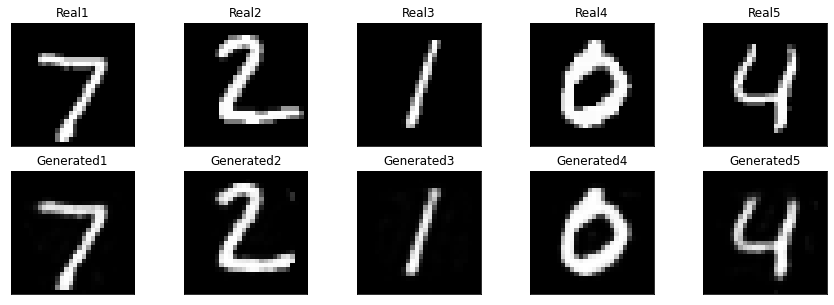

In [23]:
visual_results(x=x_test, y=pred1, n=5, cmap='gray', size=(15, 5))

#### Encoder-Decoder

In [24]:
embeddings = autoencoder.encoder.predict(flat_x_test)
embeddings.shape

(10000, 64)

In [25]:
output = autoencoder.decoder.predict(embeddings)
output.shape

(10000, 784)

In [26]:
output = output.reshape(x_test.shape)
output.shape

(10000, 28, 28, 1)

### Convolutional AutoEncoder (CAE)

+ CAE learn to encode the input image into a set of simple features and then reconstruct the input from them.
+ In this type of autoencoder, encoder layers are known as convolution layers and decoder layers are also called deconvolution layers. The deconvolution side is also known as upsampling or transpose convolution.
![Convolutional AutoEncoder](https://iq.opengenus.org/content/images/2019/07/a5.png)

#### Defining Model

In [27]:
class ConvolutionAutoEncoder:
    '''Convolutional AutoEncoder Architecture'''
    
    @staticmethod
    def build(latent_dim, original_dim, filters=(32, 64)):
        '''
            Input: latent_dim => Bottleneck Dimension
                   original_dim => Input Dimension
                   filters => list of filters for Conv2D layer
                   
            Output: It creates the architecture based on inputs
        '''
        
        # define the input to the encoder
        encoder_input = tf.keras.Input(shape=original_dim)
        x = encoder_input
        
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = tf.keras.layers.Conv2D(filters=f, kernel_size=(3, 3), strides=2, padding='same')(x)
            x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
            x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        
        # flatten the network and then construct our latent vector
        volumeSize = x.shape
        x = tf.keras.layers.Flatten()(x)
        latent = tf.keras.layers.Dense(units=latent_dim)(x)
        
        # build the encoder model
        encoder = tf.keras.Model(encoder_input, latent, name='Encoder')
        
        ###########################################################################################
        
        # define the input to the encoder
        latent_input = tf.keras.Input(shape=latent_dim)
        x = tf.keras.layers.Dense(np.prod(volumeSize[1:]))(latent_input)
        x = tf.keras.layers.Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        # loop over the number of filters in reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = tf.keras.layers.Conv2DTranspose(filters=f, kernel_size=(3, 3), strides=2, padding='same')(x)
            x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
            x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        
        # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
        x = tf.keras.layers.Conv2DTranspose(filters=original_dim[-1], kernel_size=(3, 3), padding="same")(x)
        output = tf.keras.layers.Activation("sigmoid")(x)
        
        # build the encoder model
        decoder = tf.keras.Model(latent_input, output, name='Decoder')
        
        ###########################################################################################
        
        # our autoencoder is the encoder + decoder
        autoencoder = tf.keras.Model(encoder_input, decoder(encoder(encoder_input)), name="ConvolutionAutoEncoder")
        
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

#### Initializing Model

In [28]:
conv_encoder, conv_decoder, conv_autoencoder = ConvolutionAutoEncoder.build(
    latent_dim=intermediate_dim,
    original_dim=x_train.shape[1:],
    filters=(32, 64)
)

In [29]:
conv_autoencoder.summary()

Model: "ConvolutionAutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoder (Model)              (None, 64)                219968    
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         259905    
Total params: 479,873
Trainable params: 479,489
Non-trainable params: 384
_________________________________________________________________


In [30]:
conv_encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256 

In [31]:
conv_decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        1846

#### Compiling Model

In [32]:
conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

#### Training Model

In [33]:
history2 = conv_autoencoder.fit(
    x=x_train,
    y=x_train,
    batch_size=batch_size,
    steps_per_epoch=train_batch_size,
    epochs=epochs,
    validation_data=(x_test, x_test),
    validation_steps=test_batch_size,
    shuffle=True
)

Epoch 1/5
1875/1875 [==============================] - 192s 103ms/step - loss: 0.0087 - val_loss: 0.0029
Epoch 2/5
1875/1875 [==============================] - 196s 104ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 3/5
1875/1875 [==============================] - 192s 102ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 4/5
1875/1875 [==============================] - 192s 102ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/5
1875/1875 [==============================] - 192s 102ms/step - loss: 0.0019 - val_loss: 0.0019


#### Analyzing Model

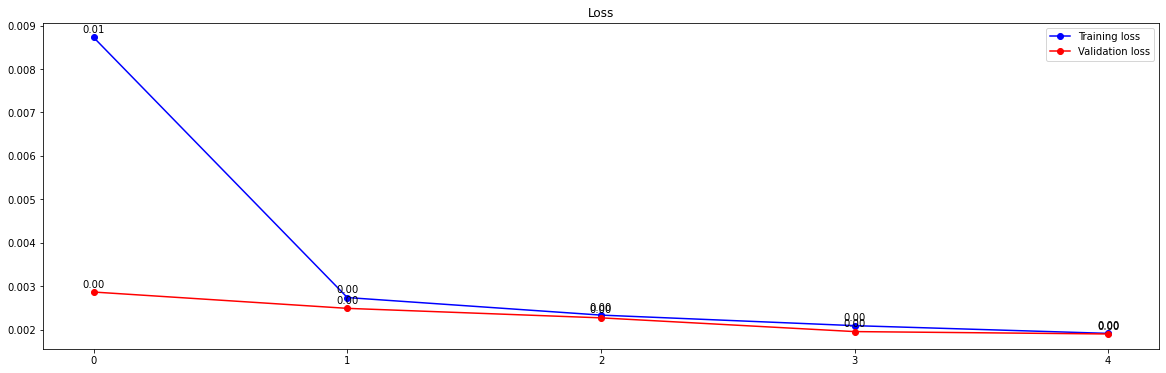

In [34]:
plot_result(history=history2)

#### Testing Model

In [35]:
pred2 = conv_autoencoder.predict(x=x_test)
pred2.shape

(10000, 28, 28, 1)

In [36]:
metrics(x=x_test, y=pred2)

Mean Squared Error (MSE) = 0.0019004939480821278
Structural Similarity Index (SSIM) = 1.0
Universal Image Quality Index (UQI) = 0.8584373453706597


#### Visualizing Results

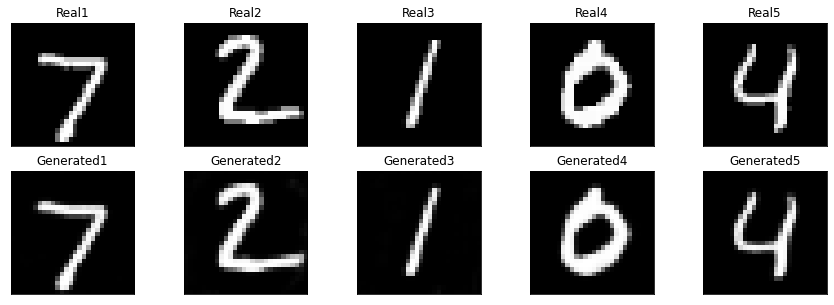

In [37]:
visual_results(x=x_test, y=pred2, n=5, cmap='gray', size=(15, 5))

#### Encoder-Decoder

In [38]:
encodings = conv_encoder.predict(x=x_test)
encodings.shape

(10000, 64)

In [39]:
output = conv_decoder.predict(x=encodings)
output.shape

(10000, 28, 28, 1)

### Sparse AutoEncoder

+ Sparse autoencoders have hidden nodes greater than input nodes. They can still discover important features from the data.
+ Sparsity constraint is introduced on the hidden layer. This is to prevent output layer copy input data.
+ Sparse autoencoders have a sparsity penalty, Ω(h), a value close to zero but not zero. Sparsity penalty is applied on the hidden layer in addition to the reconstruction error. This prevents overfitting.
+ We could, for example, add a **reguralization term** in the loss function. Doing this will make our autoencoder learn sparse representation of data.
+ Another way is to take the highest activation values in the hidden layer and **zero out** the rest of the hidden nodes. This prevents autoencoders to use all of the hidden nodes at a time and forcing only a reduced number of hidden nodes to be used.
+ As we activate and inactivate hidden nodes for each row in the dataset. Each hidden node extracts a feature from the data
![Sparse AutoEncoder](https://miro.medium.com/max/990/1*19oadmQay1n7VNarX5sIPA.png)

+ The model architecture remains the same as **Vanilla AutoEncoder** architecture.
+ But, we just add a **L1 Regularization term**.

#### Defining Model

In [40]:
class Encoder(tf.keras.layers.Layer):
    '''
        Encoder for Sparse AutoEncoder
        It instantiates tf.keras.layers.Layer
    '''
    
    def __init__(self, intermediate_dim, original_dim):
        super(Encoder, self).__init__(dtype='float32')
        # self.encoder_input = tf.keras.Input(shape=original_dim, dtype='float32')
        self.hidden_layer = tf.keras.layers.Dense(
            units=intermediate_dim,
            activation='relu',
            activity_regularizer=tf.keras.regularizers.l1(10e-5),
            input_dim=original_dim
        )
        
        
    def call(self, input_features):
        '''
            Feeds input-data to the encoder
        '''
        return self.hidden_layer(input_features)

In [41]:
class Decoder(tf.keras.layers.Layer):
    '''
        Decoder for Sparse AutoEncoder
        It instantiates tf.keras.layers.Layer
    '''
    
    def __init__(self, intermediate_dim, original_dim):
        super(Decoder, self).__init__(dtype='float32')
        # self.decoder_input = tf.keras.Input(shape=intermediate_dim, dtype='float32')
        self.output_layer = tf.keras.layers.Dense(
            units=original_dim,
            activation='sigmoid',
            input_dim=intermediate_dim
        )
        
        
    def call(self, coded_features):
        '''
            Feeds input-data to the decoder
        '''
        return self.output_layer(coded_features)

In [42]:
class SparseAutoEncoder(tf.keras.Model):
    '''Sparse AutoEncoder Architecture'''
    
    def __init__(self, intermediate_dim, original_dim):
        '''
            Input: intermediate_dim => Bottleneck Dimension
                   original_dim => Input Dimension
                   
            Output: It creates the architecture based on inputs
        '''
        super(SparseAutoEncoder, self).__init__(name='SparseAutoEncoder', dtype='float32')
        self.encoder = Encoder(intermediate_dim=intermediate_dim, original_dim=original_dim)
        self.decoder = Decoder(intermediate_dim=intermediate_dim, original_dim=original_dim)
        
        super(SparseAutoEncoder, self).build((None, original_dim))
    
    
    def call(self, input_features):
        '''
            Feeds input-data to the model architecture
        '''
        coded_features = self.encoder(input_features)
        reconstructed_input = self.decoder(coded_features)
        return reconstructed_input

#### Initializing Model

In [43]:
# selecting intermediate nodes more than input nodes
sparse_autoencoder = SparseAutoEncoder(
    intermediate_dim=high_intermediate_dim,
    original_dim=flat_x_train.shape[-1]
)
sparse_autoencoder.summary()

Model: "SparseAutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  628000    
_________________________________________________________________
decoder (Decoder)            multiple                  627984    
Total params: 1,255,984
Trainable params: 1,255,984
Non-trainable params: 0
_________________________________________________________________


In [44]:
sparse_autoencoder.encoder.submodules

(<tensorflow.python.keras.layers.core.Dense at 0x1eec5ce6948>,)

In [45]:
sparse_autoencoder.decoder.submodules

(<tensorflow.python.keras.layers.core.Dense at 0x1eea86cc248>,)

#### Compiling Model

In [46]:
sparse_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

#### Training Model

In [47]:
history3 = sparse_autoencoder.fit(
    x=flat_x_train,
    y=flat_x_train,
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=train_batch_size,
    validation_data=(flat_x_test, flat_x_test),
    validation_steps=test_batch_size,
    shuffle=True
)

Epoch 1/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1078 - val_loss: 0.0854
Epoch 2/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0829 - val_loss: 0.0806
Epoch 3/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0793 - val_loss: 0.0783
Epoch 4/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0773 - val_loss: 0.0768
Epoch 5/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0760 - val_loss: 0.0758


#### Analyzing Model

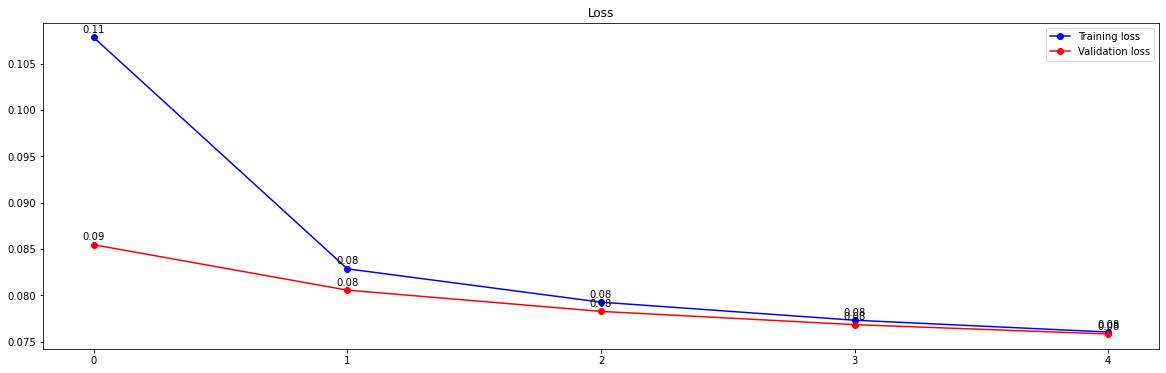

In [48]:
plot_result(history=history3)

#### Testing Model

In [49]:
pred3 = sparse_autoencoder.predict(flat_x_test).reshape(x_test.shape)
pred3.shape

(10000, 28, 28, 1)

In [50]:
metrics(x=x_test, y=pred3)

Mean Squared Error (MSE) = 0.0025657698813269436
Structural Similarity Index (SSIM) = 1.0
Universal Image Quality Index (UQI) = 0.8506969163521446


#### Visualizing Results

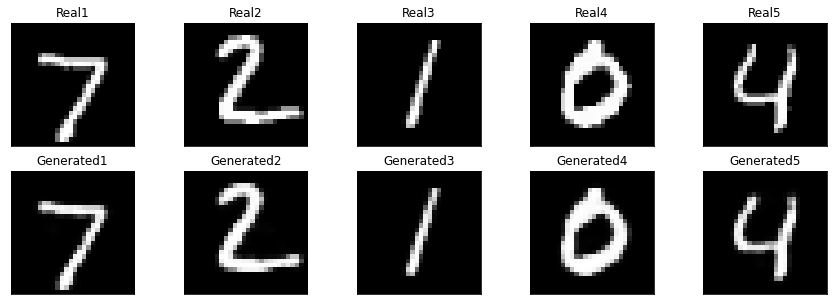

In [51]:
visual_results(x=x_test, y=pred3, n=5, cmap='gray', size=(15, 5))

#### Encoder-Decoder

In [52]:
encodings = sparse_autoencoder.encoder(flat_x_test)
encodings = np.array(encodings)
encodings.shape

(10000, 800)

In [53]:
output = sparse_autoencoder.decoder(encodings)
output = np.array(output)
output.shape

(10000, 784)

In [54]:
output = output.reshape(x_test.shape)
output.shape

(10000, 28, 28, 1)

### Denoising AutoEncoder

+ Denoising autoencoders add some noise to the input image and learn to remove it. Thus avoiding to copy the input to the output without learning features about the data. These autoencoders take a partially corrupted input while training to recover the original undistorted input.
+ The model learns a vector field for mapping the input data towards a lower-dimensional manifold which describes the natural data to cancel out the added noise. By this means, the encoder will extract the most important features and learn a more robust representation of the data.
![Denoising AutoEncoders](https://iq.opengenus.org/content/images/2019/07/a1.png)

+ The model architecture remains the same as **Convolutional AutoEncoder** architecture.
+ But, here we will be building architecture slightly different from before.
+ Input images fed to the model are noisy.

#### Defining Model

In [55]:
class DenoisingAutoEncoder:
    '''Denoising/Convolutional AutoEncoder Architecture'''
    
    @staticmethod
    def build(latent_dim, original_dim, filters=(32, 64)):
        '''
            Input: latent_dim => Bottleneck Dimension
                   original_dim => Input Dimension
                   filters => list of filters for Conv2D layer
                   
            Output: It creates the architecture based on inputs
        '''
        
        # define the input to the encoder
        encoder_input = tf.keras.Input(shape=original_dim)
        x = encoder_input
        
        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = tf.keras.layers.Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu')(x)
            x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
        
        # flatten the network and then construct our latent vector
        volumeSize = x.shape
        x = tf.keras.layers.Flatten()(x)
        latent = tf.keras.layers.Dense(units=latent_dim)(x)
        
        # build the encoder model
        encoder = tf.keras.Model(encoder_input, latent, name='Encoder')
        
        ###########################################################################################
        
        # define the input to the encoder
        latent_input = tf.keras.Input(shape=latent_dim)
        x = tf.keras.layers.Dense(np.prod(volumeSize[1:]))(latent_input)
        x = tf.keras.layers.Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
        
        # loop over the number of filters in reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = tf.keras.layers.Conv2D(filters=f, kernel_size=(3, 3), padding='same', activation='relu')(x)
            x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        
        # apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
        x = tf.keras.layers.Conv2DTranspose(filters=original_dim[-1], kernel_size=(3, 3), padding="same")(x)
        output = tf.keras.layers.Activation("sigmoid")(x)
        
        # build the encoder model
        decoder = tf.keras.Model(latent_input, output, name='Decoder')
        
        ###########################################################################################
        
        # our autoencoder is the encoder + decoder
        autoencoder = tf.keras.Model(encoder_input, decoder(encoder(encoder_input)), name="DenoisingAutoEncoder")
        
        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

#### Preparing Data for Model

+ Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [56]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#### Initializing Model

In [57]:
dconv_encoder, dconv_decoder, dconv_autoencoder = DenoisingAutoEncoder.build(
    latent_dim=intermediate_dim,
    original_dim=x_train_noisy.shape[1:]
)

In [58]:
dconv_autoencoder.summary()

Model: "DenoisingAutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoder (Model)              (None, 64)                219584    
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         259521    
Total params: 479,105
Trainable params: 479,105
Non-trainable params: 0
_________________________________________________________________


In [59]:
dconv_encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2007

In [60]:
dconv_decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              203840    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)        0   

#### Compiling Model

In [61]:
dconv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')

#### Training Model

In [62]:
history4 = dconv_autoencoder.fit(
    x=x_train_noisy,
    y=x_train,
    batch_size=batch_size,
    steps_per_epoch=train_batch_size,
    epochs=epochs,
    validation_data=(x_test_noisy, x_test),
    validation_steps=test_batch_size,
    shuffle=True
)

Epoch 1/5
1875/1875 [==============================] - 180s 96ms/step - loss: 0.1332 - val_loss: 0.1006
Epoch 2/5
1875/1875 [==============================] - 179s 95ms/step - loss: 0.0994 - val_loss: 0.0967
Epoch 3/5
1875/1875 [==============================] - 164s 88ms/step - loss: 0.0961 - val_loss: 0.0952
Epoch 4/5
1875/1875 [==============================] - 164s 88ms/step - loss: 0.0944 - val_loss: 0.0944
Epoch 5/5
1875/1875 [==============================] - 169s 90ms/step - loss: 0.0933 - val_loss: 0.0939


#### Analyzing Model

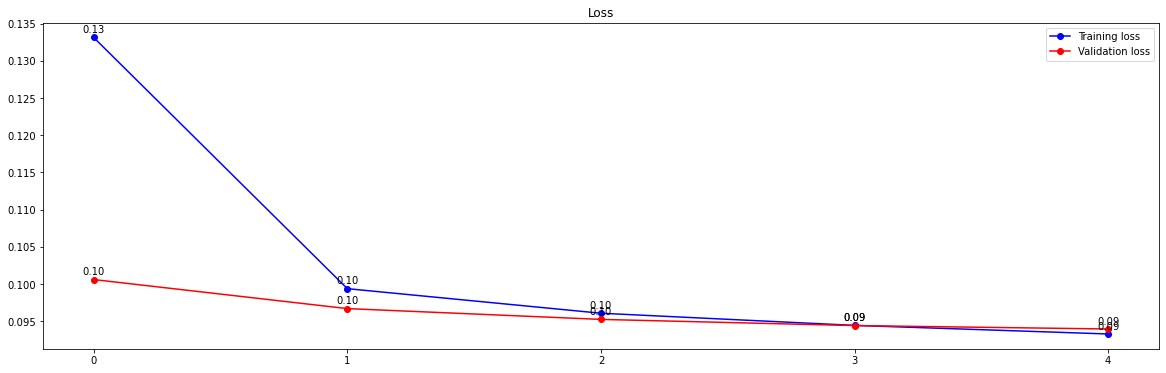

In [63]:
plot_result(history=history4)

#### Testing Model

In [64]:
pred4 = dconv_autoencoder.predict(x=x_test_noisy)
pred4.shape

(10000, 28, 28, 1)

In [65]:
metrics(x=x_test, y=pred4)

Mean Squared Error (MSE) = 0.010522867838626911
Structural Similarity Index (SSIM) = 1.0
Universal Image Quality Index (UQI) = 0.7889492312734027


#### Visualizing Results

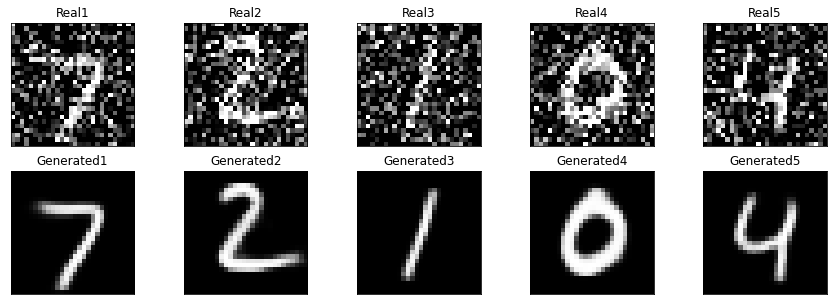

In [66]:
visual_results(x=x_test_noisy, y=pred4, n=5, cmap='gray', size=(15, 5))

#### Encoder-Decoder

In [67]:
encodings = dconv_encoder.predict(x=x_test_noisy)
encodings.shape

(10000, 64)

In [68]:
output = dconv_decoder.predict(x=encodings)
output.shape

(10000, 28, 28, 1)

### Contractive AutoEncoder

+ The objective of a contractive autoencoder is to have a robust learned representation which is less sensitive to small variation in the data. Robustness of the representation for the data is done by applying a penalty term to the loss function.
+ Contractive autoencoder is another regularization technique just like sparse and denoising autoencoders. However, this regularizer corresponds to the **Frobenius norm of the Jacobian matrix** of the encoder activations with respect to the input. Frobenius norm of the Jacobian matrix for the hidden layer is calculated with respect to input and it is basically the sum of square of all elements.
+ Contractive autoencoder is a better choice than denoising autoencoder to learn useful feature extraction.
![Contractive AutoEncoder](https://iq.opengenus.org/content/images/2019/07/a4.png)
![Loss function with penalty term — Frobenius norm of the Jacobian matrix](https://miro.medium.com/max/326/1*FjATD2EW-bFB4vTQ6ikR4w.png)

+ The model architecture remains the same as **Vanilla AutoEncoder** architecture.
+ But, loss function is different from before.

#### Defining Loss Function

In [69]:
def contractive_loss(model, lambda_param):
    
    def loss(y_pred, y_true):
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)

        W = model.encoder.weights[0]  # N x N_hidden
        W = tf.transpose(W)           # N_hidden x N
        h = model.encoder(y_true)
        dh = h * (1 - h)              # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lambda_param*tf.reduce_sum(tf.square(dh)*tf.reduce_sum(tf.square(W), axis=1), axis=1)

        return mse + contractive
    
    return loss

#### Initializing Model

In [70]:
# using VanillaAutoEncoder & selecting intermediate nodes more than input nodes
contractive_autoencoder = VanillaAutoEncoder(
    intermediate_dim=high_intermediate_dim,
    original_dim=flat_x_train.shape[-1]
)

#### Compiling Model

In [71]:
contractive_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=contractive_loss(model=contractive_autoencoder, lambda_param=1e-4)
)

#### Training Model

In [72]:
history5 = contractive_autoencoder.fit(
    x=flat_x_train,
    y=flat_x_train,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=train_batch_size,
    validation_data=(flat_x_test, flat_x_test),
    validation_steps=test_batch_size,
    shuffle=True
)

Epoch 1/5
1875/1875 [==============================] - 59s 31ms/step - loss: 0.0102 - val_loss: 0.0038
Epoch 2/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/5
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 4/5
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0023 - val_loss: 0.0022


#### Analyzing Model

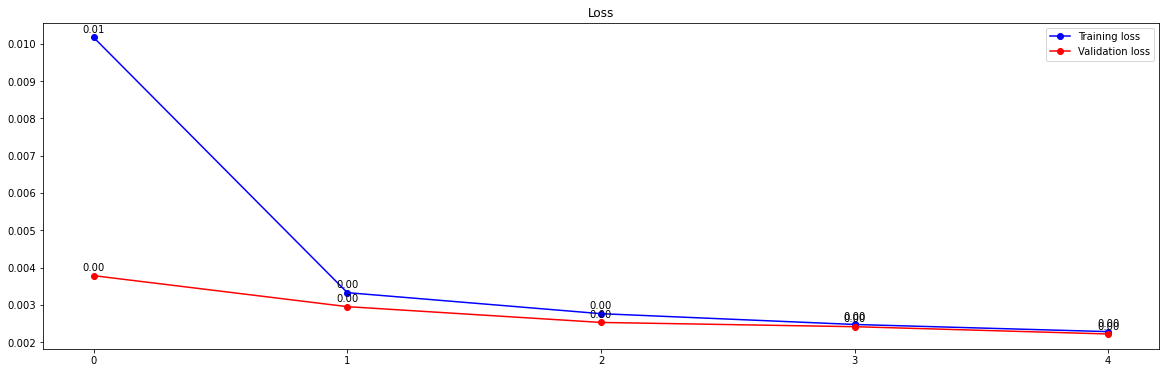

In [73]:
plot_result(history=history5)

#### Testing Model

In [74]:
pred5 = contractive_autoencoder.predict(x=flat_x_test).reshape(x_test.shape)
pred5.shape

(10000, 28, 28, 1)

In [75]:
metrics(x=x_test, y=pred5)

Mean Squared Error (MSE) = 0.0015804153576458898
Structural Similarity Index (SSIM) = 1.0
Universal Image Quality Index (UQI) = 0.8499299368496162


#### Visualizing Results

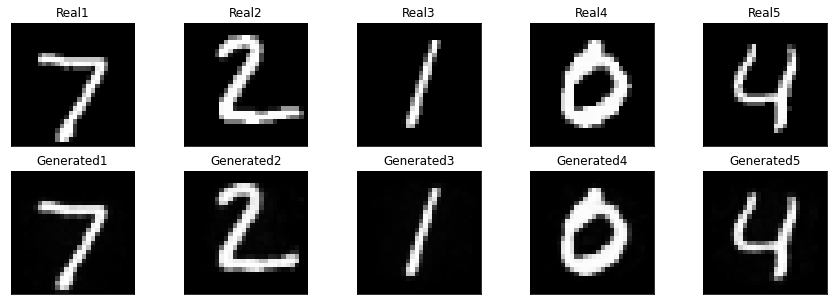

In [76]:
visual_results(x=x_test, y=pred5, n=5, cmap='gray', size=(15, 5))

#### Encoder-Decoder

In [77]:
encodings = contractive_autoencoder.encoder.predict(x=flat_x_test)
encodings.shape

(10000, 800)

In [78]:
output = contractive_autoencoder.decoder.predict(x=encodings)
output.shape

(10000, 784)

In [79]:
output = output.reshape(x_test.shape)
output.shape

(10000, 28, 28, 1)

### Deep AutoEncoder

+ Deep Autoencoders consist of two identical deep belief networks, One network for encoding and another for decoding. Typically deep autoencoders have 4 to 5 layers for encoding and the next 4 to 5 layers for decoding. We use unsupervised layer by layer pre-training for this model.
+ The layers are Restricted Boltzmann Machines which are the building blocks of deep-belief networks.
+ Deep autoencoders are useful in topic modeling, or statistically modeling abstract topics that are distributed across a collection of documents. They are also capable of compressing images into 30 number vectors.
![Deep AutoEncoder](https://miro.medium.com/max/1400/1*QM1b0gbKdMowkmyvO95DFA.png)

### Convolutional Variational AutoEncoder (VAE)

+ VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data compress it into a smaller representation.
+ This type of autoencoder can generate new images just like GANs.
+ Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian.
+ They use a variational approach for latent representation learning, which results in an additional loss component and a specific estimator for the training algorithm called the **Stochastic Gradient Variational Bayes** estimator.
+ The probability distribution of the latent vector of a variational autoencoder typically matches the training data much closer than a standard autoencoder. 
+ This approach produces a continuous, structured latent space, which is useful for image generation.
+ As VAEs are much more flexible and customisable in their generation behaviour than GANs, they are suitable for art generation of any kind.
![Convolutional Variational AutoEncoder](https://iq.opengenus.org/content/images/2019/07/a6.png)

In [80]:
class CVAE(tf.keras.Model):
    """Convolutional Variational AutoEncoder."""
    
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])

    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [81]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [82]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

+ Note: **Incomplete**
    - https://www.tensorflow.org/tutorials/generative/cvae